# 使用geatpy优化RNN定位模型参数

In [ ]:
import math
import numpy as np
import pandas as pd
import geatpy as ea
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN, LSTM
from multiprocessing.dummy import Pool as ThreadPool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, explained_variance_score, r2_score, mean_squared_error

## 读取数据

In [ ]:
# 加载训练数据
def load_data(path):
    df = pd.read_csv(path)
    dv = df.values
    X = dv[:, 1:-2]
    Y = dv[:, -2:]
    return X[:, :, np.newaxis], Y

In [20]:
X, y = load_data('./dataset/location_data.csv')
X = np.reshape(X, newshape=(2000, 100))
print(X.shape)

(2000, 100)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)  # 训练测试划分

## 定义RNN模型

In [22]:
def RFID_RNN():
#     model = Sequential()
#     model.add(SimpleRNN(units=100,
#                         # kernel_initializer=initializers.RandomNormal(stddev=0.001),
#                         # recurrent_initializer=initializers.Identity(gain=1.0),
#                         batch_input_shape=(None, 100, 1)))
#     model.add(Dense(2))
#     model.compile(optimizer='adam',
#                   loss='mse',
#                   metrics=['mae'])

#     # model.summary()
#     return model
    model = Sequential()
    model.add(Dense(100, batch_input_shape=(None, 100), activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(2))
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['mae'])
    # model.summary()
    return model

## 训练模型查看测试效果

In [28]:
%%time
model = RFID_RNN()
model.fit(X_train, y_train, epochs=480, batch_size=55, verbose=0)
loss = model.evaluate(X_test, y_test, batch_size=10) # 输出损失和MAE
print('损失与精度：', loss)
model.save('./models/RNN_2021_double.h5')

pxy = model.predict(X_test)
print(pxy[:10])
print(y_test[:10])
MAE = mean_absolute_error(y_test, pxy)
MSE = mean_squared_error(y_test, pxy)
r2 = r2_score(y_test, pxy)
ev = explained_variance_score(y_test, pxy)
print('MAE指标:', MAE)
print('MSE指标:', MSE)
print('RMSE指标:', math.sqrt(MSE))
print('r2指标:', r2)
print('ev指标:', ev)


40/40 [==============================] - 0s 779us/step - loss: 0.4876 - mae: 0.5481
损失与精度： [0.48758193850517273, 0.5480815768241882]
[[3.9083402 3.6166646]
 [1.6810801 4.4629498]
 [5.3626328 7.554553 ]
 [8.3395    8.197536 ]
 [7.5265093 8.070725 ]
 [8.025873  8.264883 ]
 [7.381713  4.881274 ]
 [4.158865  8.725903 ]
 [8.590054  2.2265537]
 [2.6489    2.3421376]]
[[3.76 3.77]
 [1.57 4.63]
 [5.43 6.77]
 [9.67 7.94]
 [7.09 8.28]
 [8.59 8.24]
 [9.14 2.22]
 [3.66 7.91]
 [8.93 1.86]
 [2.38 2.02]]
MAE指标: 0.5480817054480317
MSE指标: 0.4875820421832129
RMSE指标: 0.6982707513445002
r2指标: 0.9343388253106997
ev指标: 0.9345498849584739
CPU times: user 17.7 s, sys: 5.93 s, total: 23.6 s
Wall time: 11 s


## 使用进化算法调参

 ### 自定义问题类

In [26]:
class RFIDRNN(ea.Problem):
    def __init__(self, X_train, X_test, y_train, y_test):
        name = 'RFIDRNN'
        M = 2 # 初始化M（目标维数）
        maxormins = [1, -1] # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = 2 # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim) # 初始化varTypes 0-连续
        lb = [10, 50] # 决策变量下界
        ub = [500, 800] # 决策变量上界
        lbin = [1] * Dim # 决策变量下边界（0表示不包含该变量的下边界，1表示包含）
        ubin = [1] * Dim # 决策变量上边界（0表示不包含该变量的上边界，1表示包含）
        # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
        # 数据设置
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        
    # 目标函数，采用多线程加速计算
    def aimFunc(self, pop):
        Vars = pop.Phen # 得到决策变量矩阵
        # print(Vars)
        pop.ObjV = np.zeros((pop.sizes, 2)) # 初始化种群个体目标函数值列向量
        # print(pop.ObjV[0][1])
        def subAimFunc(i):
            epochs = int(Vars[i, 0])
            batch_size = int(Vars[i, 1])
            model = RFID_RNN()
            model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            loss = model.evaluate(self.X_test, self.y_test, batch_size=10)
            pxy = model.predict(self.X_test)
            pop.ObjV[i][0] = loss[0]
            pop.ObjV[i][1] = r2_score(self.y_test, pxy)
        pool = ThreadPool(processes=2) # 设置池的大小
        pool.map(subAimFunc, list(range(pop.sizes))) # 散列种群每个个体进行加速计算
        
        
    # 代入优化后的参数对测试集进行检验，计算指标
    def test(self, epochs, batch_size):
        X02, y02 = load_data('./dataset/location_data02.csv')
        X02 = np.reshape(X02, newshape=(20, 100))
        model = RFID_RNN()
        model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        model.save('./models/RNN_2021_double.h5')
        pxy = model.predict(X02)
        MAE = mean_absolute_error(y02, pxy)
        MSE = mean_squared_error(y02, pxy)
        r2 = r2_score(y02, pxy)
        ev = explained_variance_score(y02, pxy)
        print('MAE指标:', MAE)
        print('MSE指标:', MSE)
        print('RMSE指标', math.sqrt(MSE))
        print('r2指标:', r2)
        print('ev指标:', ev)
        

### 编写执行代码

40/40 [==============================] - 0s 651us/step - loss: 0.5078 - mae: 0.5433
gen|  eval  |      hv     |   spacing   
----------------------------------------
 0 |   10   | 8.26446E-03 |     NAN     


/Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


40/40 [==============================] - 0s 713us/step - loss: 0.5488 - mae: 0.5890
 1 |   20   | 8.26446E-03 | 0.00000E+00 
40/40 [==============================] - 0s 772us/step - loss: 3.7587 - mae: 1.5933
 2 |   30   | 8.26446E-03 | 0.00000E+00 
40/40 [==============================] - 0s 778us/step - loss: 0.5580 - mae: 0.5850
 3 |   40   | 8.26446E-03 | 0.00000E+00 
40/40 [==============================] - 0s 777us/step - loss: 0.7358 - mae: 0.6724
 4 |   50   | 8.26446E-03 | 0.00000E+00 
40/40 [==============================] - 0s 851us/step - loss: 0.9204 - mae: 0.7633
 5 |   60   | 8.26446E-03 | 0.00000E+00 
40/40 [==============================] - 0s 750us/step - loss: 0.5772 - mae: 0.5845
 6 |   70   | 8.26446E-03 | 0.00000E+00 
40/40 [==============================] - 0s 846us/step - loss: 3.7487 - mae: 1.6051
 7 |   80   | 8.26446E-03 | 0.00000E+00 
40/40 [==============================] - 0s 847us/step - loss: 0.7344 - mae: 0.6767
 8 |   90   | 8.26446E-03 | 0.00000E+00 


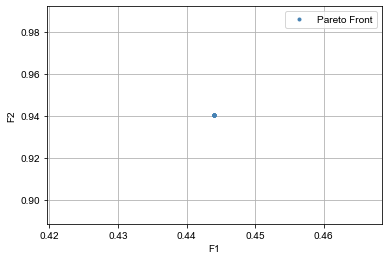

种群信息导出完毕。
用时：951.293703 秒
评价次数：100 次
最优的目标函数值为：0.4440412223339081
最优的控制变量值为：
479.52873967044536
55.48681186260416


ValueError: in user code:

    /Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /Users/frank/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_5 is incompatible with the layer: expected axis -1 of input shape to have value 100 but received input with shape (None, 100, 1)


In [27]:
"""===============================实例化问题对象==========================="""

problem = RFIDRNN(X_train, X_test, y_train, y_test) # 生成问题对象

"""=================================种群设置==============================="""

Encoding = 'RI'       # 编码方式
NIND = 10             # 种群规模
Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges, problem.borders) # 创建区域描述器
population = ea.Population(Encoding, Field, NIND) # 实例化种群对象（此时种群还没被初始化，仅仅是完成种群对象的实例化）

"""===============================算法参数设置============================="""

myAlgorithm = ea.moea_MOEAD_templet(problem, population) # 实例化一个算法模板对象
myAlgorithm.MAXGEN = 10 # 最大进化代数
myAlgorithm.trappedValue = 1e-6 # “进化停滞”判断阈值
myAlgorithm.maxTrappedCount = 10 # 进化停滞计数器最大上限值，如果连续maxTrappedCount代被判定进化陷入停滞，则终止进化
myAlgorithm.logTras = 1  # 设置每隔多少代记录日志，若设置成0则表示不记录日志
myAlgorithm.verbose = True  # 设置是否打印输出日志信息
myAlgorithm.drawing = 1  # 设置绘图方式（0：不绘图；1：绘制结果图；2：绘制目标空间过程动画；3：绘制决策空间过程动画）

"""===========================调用算法模板进行种群进化======================="""

[BestIndi, population] = myAlgorithm.run()  # 执行算法模板，得到最优个体以及最后一代种群
BestIndi.save()  # 把最优个体的信息保存到文件中

"""==================================输出结果============================="""

print('用时：%f 秒' % myAlgorithm.passTime)
print('评价次数：%d 次' % myAlgorithm.evalsNum)
if BestIndi.sizes != 0:
    print('最优的目标函数值为：%s' % BestIndi.ObjV[0][0])
    print('最优的控制变量值为：')
    for i in range(BestIndi.Phen.shape[1]):
        print(BestIndi.Phen[0, i])
else:
    print('没找到可行解。')
    
"""=================================检验结果==============================="""

problem.test(epochs= int(BestIndi.Phen[0][0]), batch_size= int(BestIndi.Phen[0][1]))
